In [62]:
import pandas as pd
import ixmp as ix
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [63]:
mp = ix.Platform(dbtype='HSQLDB')

INFO:root:launching ixmp.Platform with local HSQLDB database at 'C:\Users\ga46gup\.local\ixmp\localdb\default'


In [64]:
base = message_ix.Scenario(mp, model='Westeros Electrified', 
                               scen='carbon_tax')

In [65]:
model = 'Westeros Electrified'
scen = base.clone(model, 'firm_capacity','testing new formulation', keep_sol=False)
scen.check_out()

vintage_years, act_years = scen.vintage_and_active_years()
model_horizon = scen.set('year')
country = 'Westeros'

## add Renewbale Formulation


### Load Factors - Describing the Electricity Sector
#### Peak load 
If we further specify our demand, we will find that the demand for electricity (!not the demand for useful light but for electricity!) has a peak load that is different from the annual average load; e.g: if annual average load is 5 GWh peak load during midday might be 10GW --> the peak load factor is equal to 2.

In [66]:
# peak_load_factor(node,commodity,level,year,time)
peak_load_factor = pd.DataFrame({
        'node': country,
        'commodity': 'electricity',
        'level' : 'secondary',       
        'year': model_horizon,
        'time' : 'year',
        'value' : 2,
        'unit' : '???'})

scen.add_par('peak_load_factor', peak_load_factor)

## Describing the Renewable Technologies Reliability
### rating and reliability --> Ensuring enough Firm Capacity
we assume, that up to a share of 20% of total electricity supply, the capacity of wind_ppl adds by 80% to the firm capacity of the power system (r1). The remaining 90% installed capacity, however  only  5% contribute to the firm capcity (r2). The coal power plant supplies full reliability independet of the supply share.


In [67]:
base_reliability = pd.DataFrame({
        'node': country,
        'commodity': 'electricity',
        'level' : 'secondary', 
        'unit': '???',
        'time': 'year',
        'year_act': model_horizon})

In [68]:
# add the ratings as a set 
scen.add_set('rating', ['r1', 'r2'])

# for Wind PPL
rating_bin = make_df(base_reliability, technology= 'wind_ppl', value = 0.2, rating= 'r1')
scen.add_par('rating_bin', rating_bin)

reliability_factor = make_df(base_reliability, technology= 'wind_ppl', value = 0.99, rating= 'r1')
scen.add_par('reliability_factor', reliability_factor)

rating_bin = make_df(base_reliability, technology= 'wind_ppl', value = 0.3, rating= 'r2')
scen.add_par('rating_bin', rating_bin)

reliability_factor = make_df(base_reliability, technology= 'wind_ppl', value = 0.00, rating= 'r2')
scen.add_par('reliability_factor', reliability_factor)

# for Coal PPL
reliability_factor = make_df(base_reliability, technology= 'coal_ppl', value = 1, rating= 'firm')
scen.add_par('reliability_factor', reliability_factor)

### commit and solve

In [69]:
scen.commit(comment='define parameters for renewable implementation')
scen.set_as_default()

In [70]:
scen.solve()

In [71]:
scen.var('OBJ')['lvl']

586893.9375

### plotting

In [72]:
from tools import Plots
p = Plots(scen, country, firstyear=700)

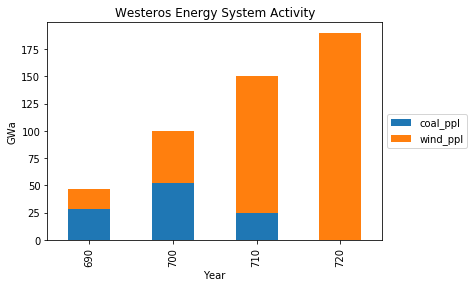

In [73]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

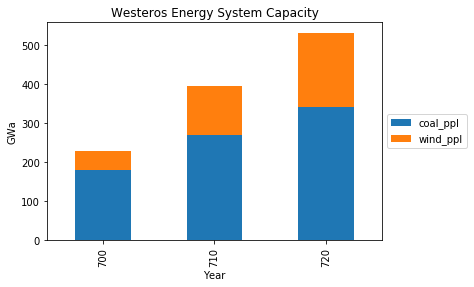

In [74]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

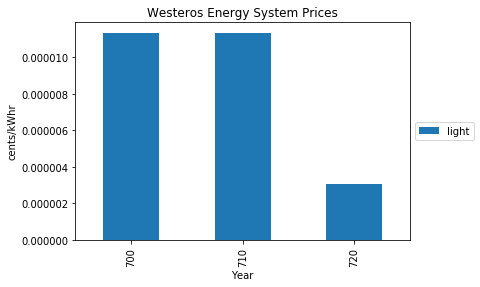

In [75]:
p.plot_prices(subset=['light'], baseyear=True)

In [76]:
mp.close_db()